In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 28, 18
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('AirPassengers.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [3]:
df.head(10)

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


In [4]:
df['Month'] = pd.to_datetime(df['Month'], infer_datetime_format = True)
ts = df.set_index(['Month'])

In [5]:
ts.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


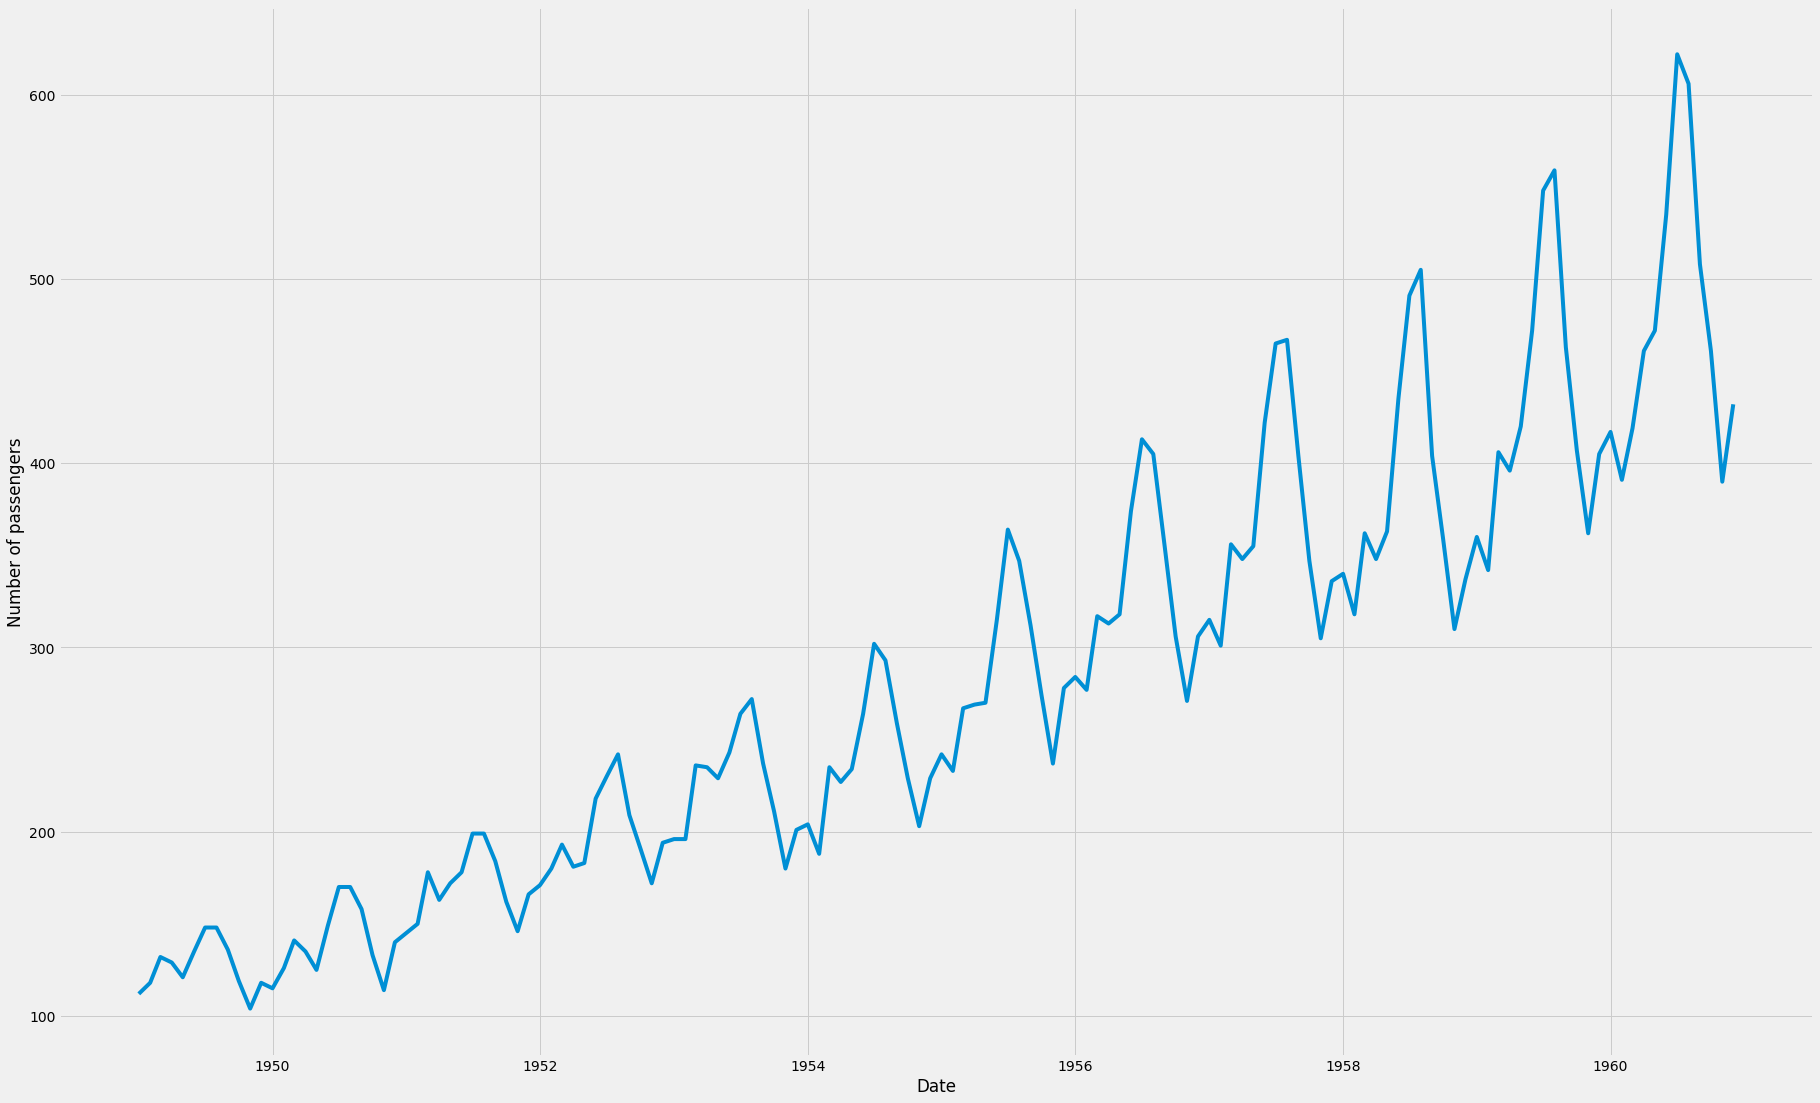

In [6]:
plt.xlabel('Date')
plt.ylabel('Number of passengers')
plt.plot(ts)

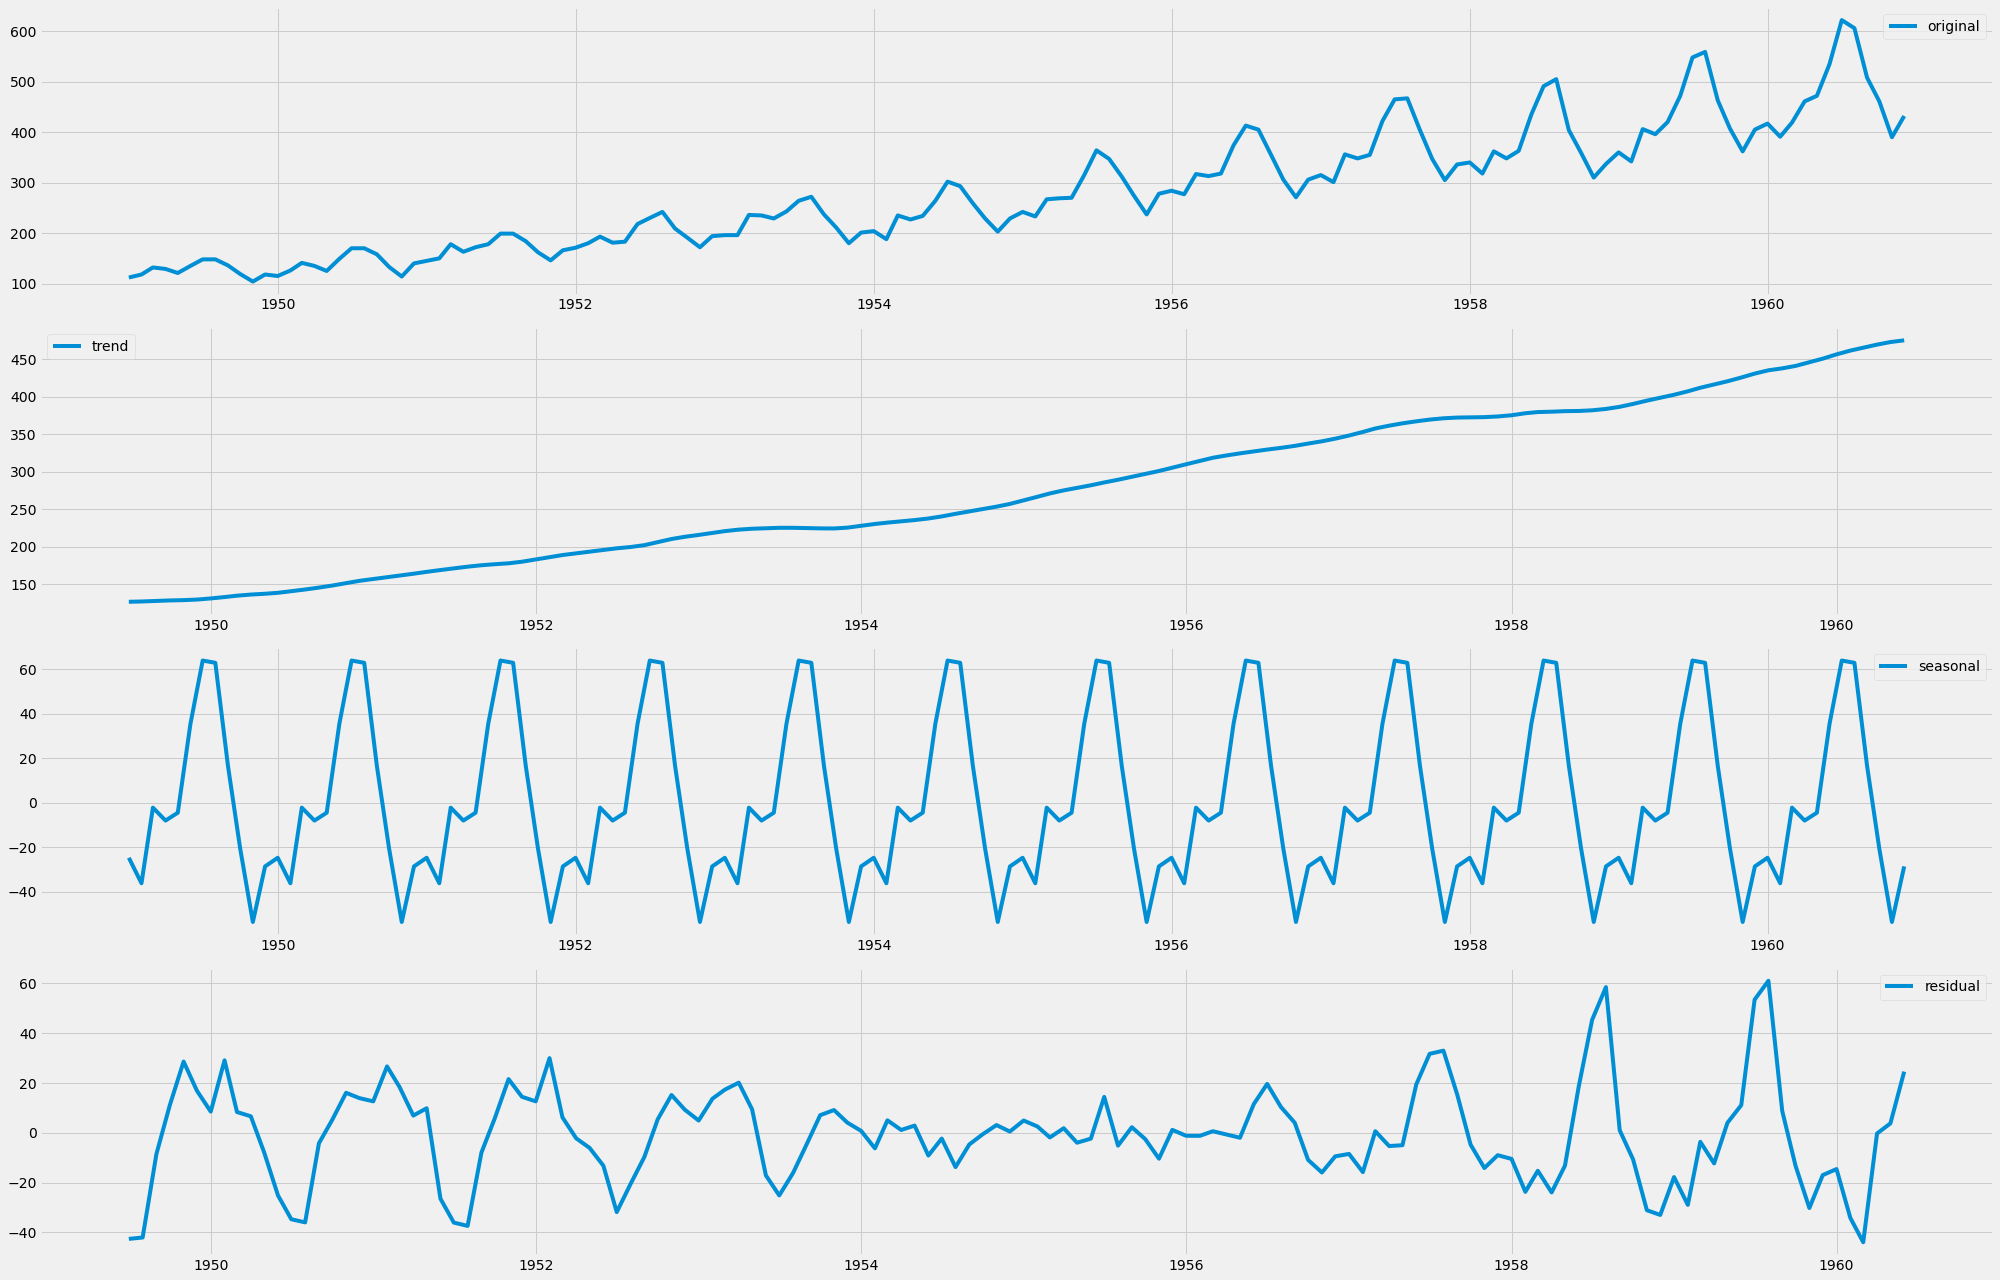

In [7]:
# decomposition of trend, seasonal, residual

decomposition = seasonal_decompose(ts)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts, label = 'original')
plt.legend(loc = 'best')

plt.subplot(412)
plt.plot(trend, label = 'trend')
plt.legend(loc = 'best')

plt.subplot(413)
plt.plot(seasonal, label = 'seasonal')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual, label = 'residual')
plt.legend(loc = 'best')
plt.tight_layout()

In [8]:
def TestStationaryPlot(ts):
    rol_mean = ts.rolling(window = 12, center = False).mean()
    rol_std = ts.rolling(window = 12, center = False).std()
    
    plt.plot(ts, color = 'blue', label = 'orginal')
    plt.plot(rol_mean, color = 'red', linestyle = '-.', label = 'moving average')
    plt.plot(rol_std, color='black', linestyle = '--', label = 'std')
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)
    
    plt.xlabel('Time(Year)', fontsize = 25)
    plt.ylabel('Total Emissions', fontsize = 25)
    plt.legend(loc= 'best', fontsize = 18)
    plt.title('Moving average and standard deviation', fontsize = 27)
    plt.show(block = True)

In [9]:
def TestStationaryAdfuller(ts, cutoff = 0.01):
    ts_test = adfuller(ts, autolag = 'AIC')
    ts_test_output = pd.Series(ts_test[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Oberservations Used'])
    
    for key, value in ts_test[4].items():
        ts_test_output['Critical Value (%s)' %key] = value
    print(ts_test_output)
    
    if ts_test[1] <= cutoff:
        print('Reject Null hypothesis, the time series is stable')
    else:
        print('Cannot reject Null Hypothesis, the time series is not stable')

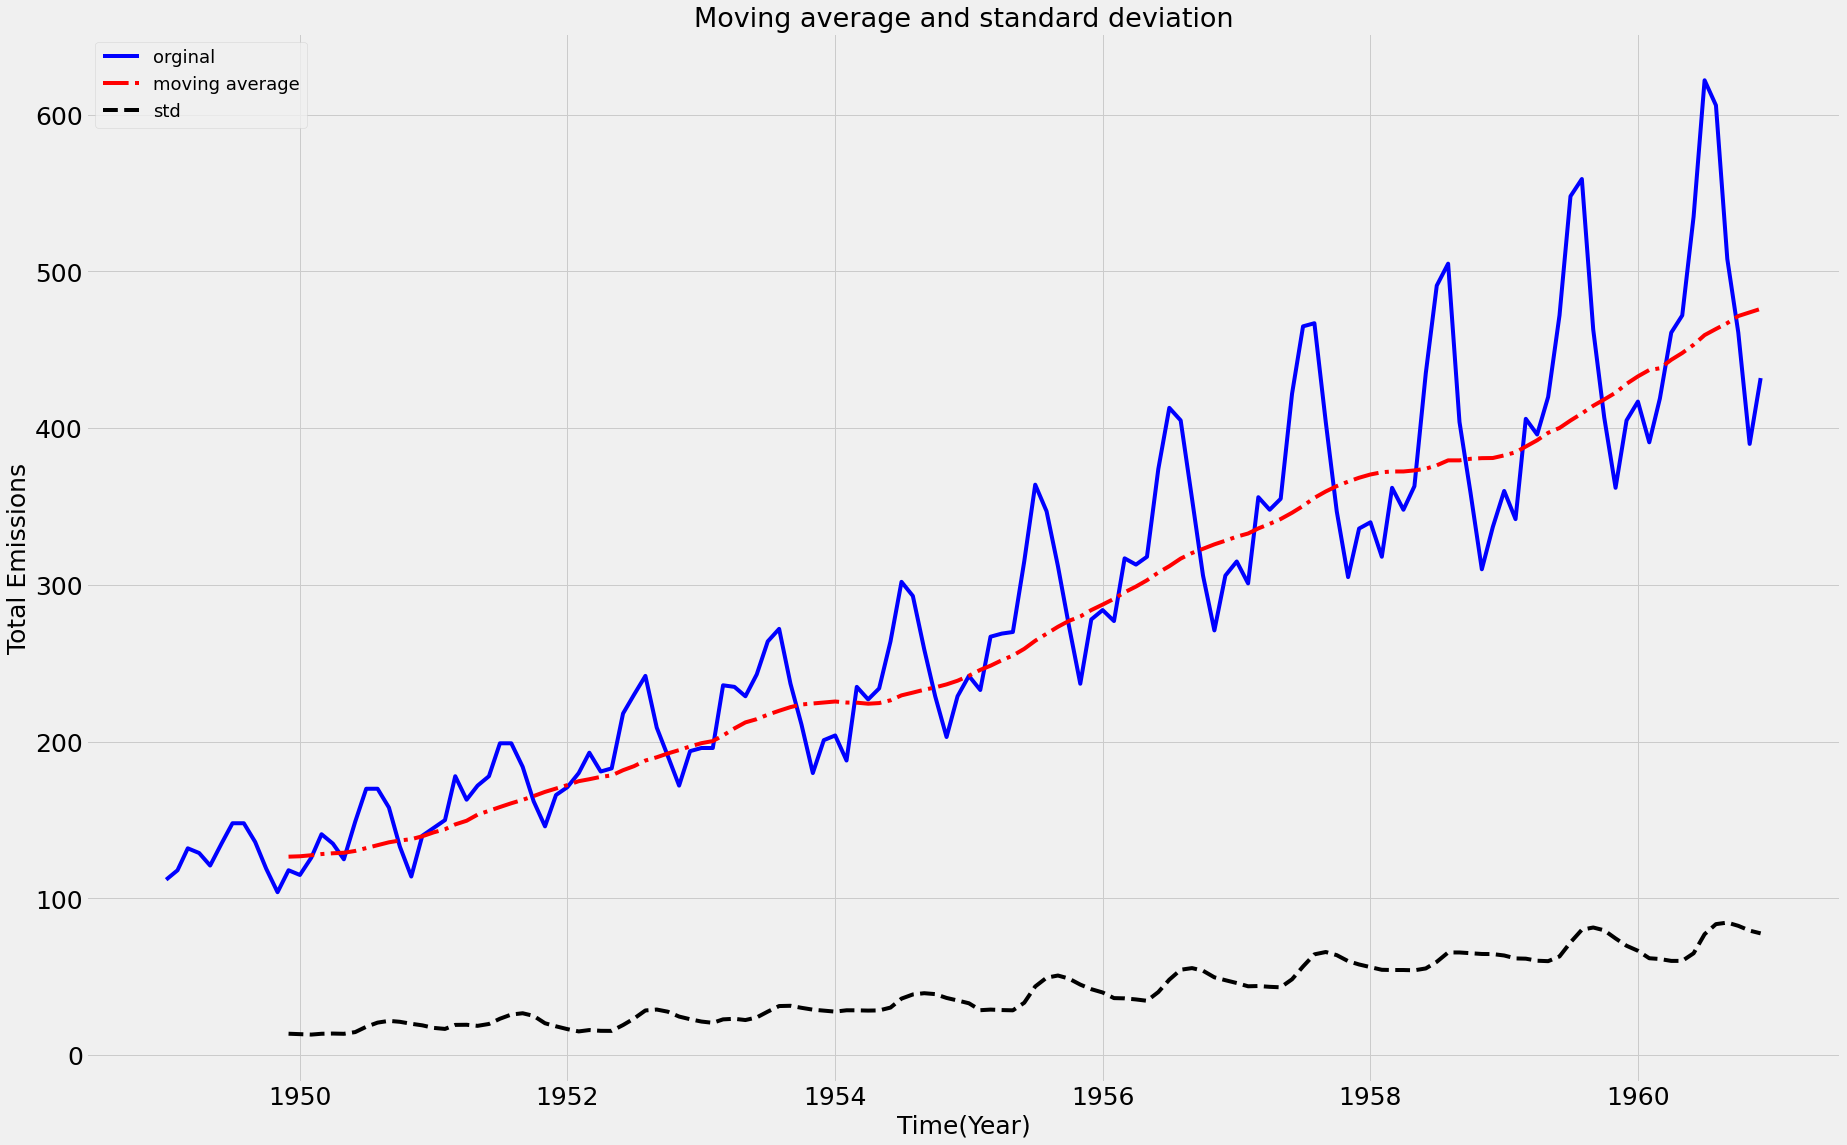

Test Statistic                     0.815369
p-value                            0.991880
#Lags Used                        13.000000
Number of Oberservations Used    130.000000
Critical Value (1%)               -3.481682
Critical Value (5%)               -2.884042
Critical Value (10%)              -2.578770
dtype: float64
Cannot reject Null Hypothesis, the time series is not stable


In [10]:
TestStationaryPlot(ts)
TestStationaryAdfuller(ts)

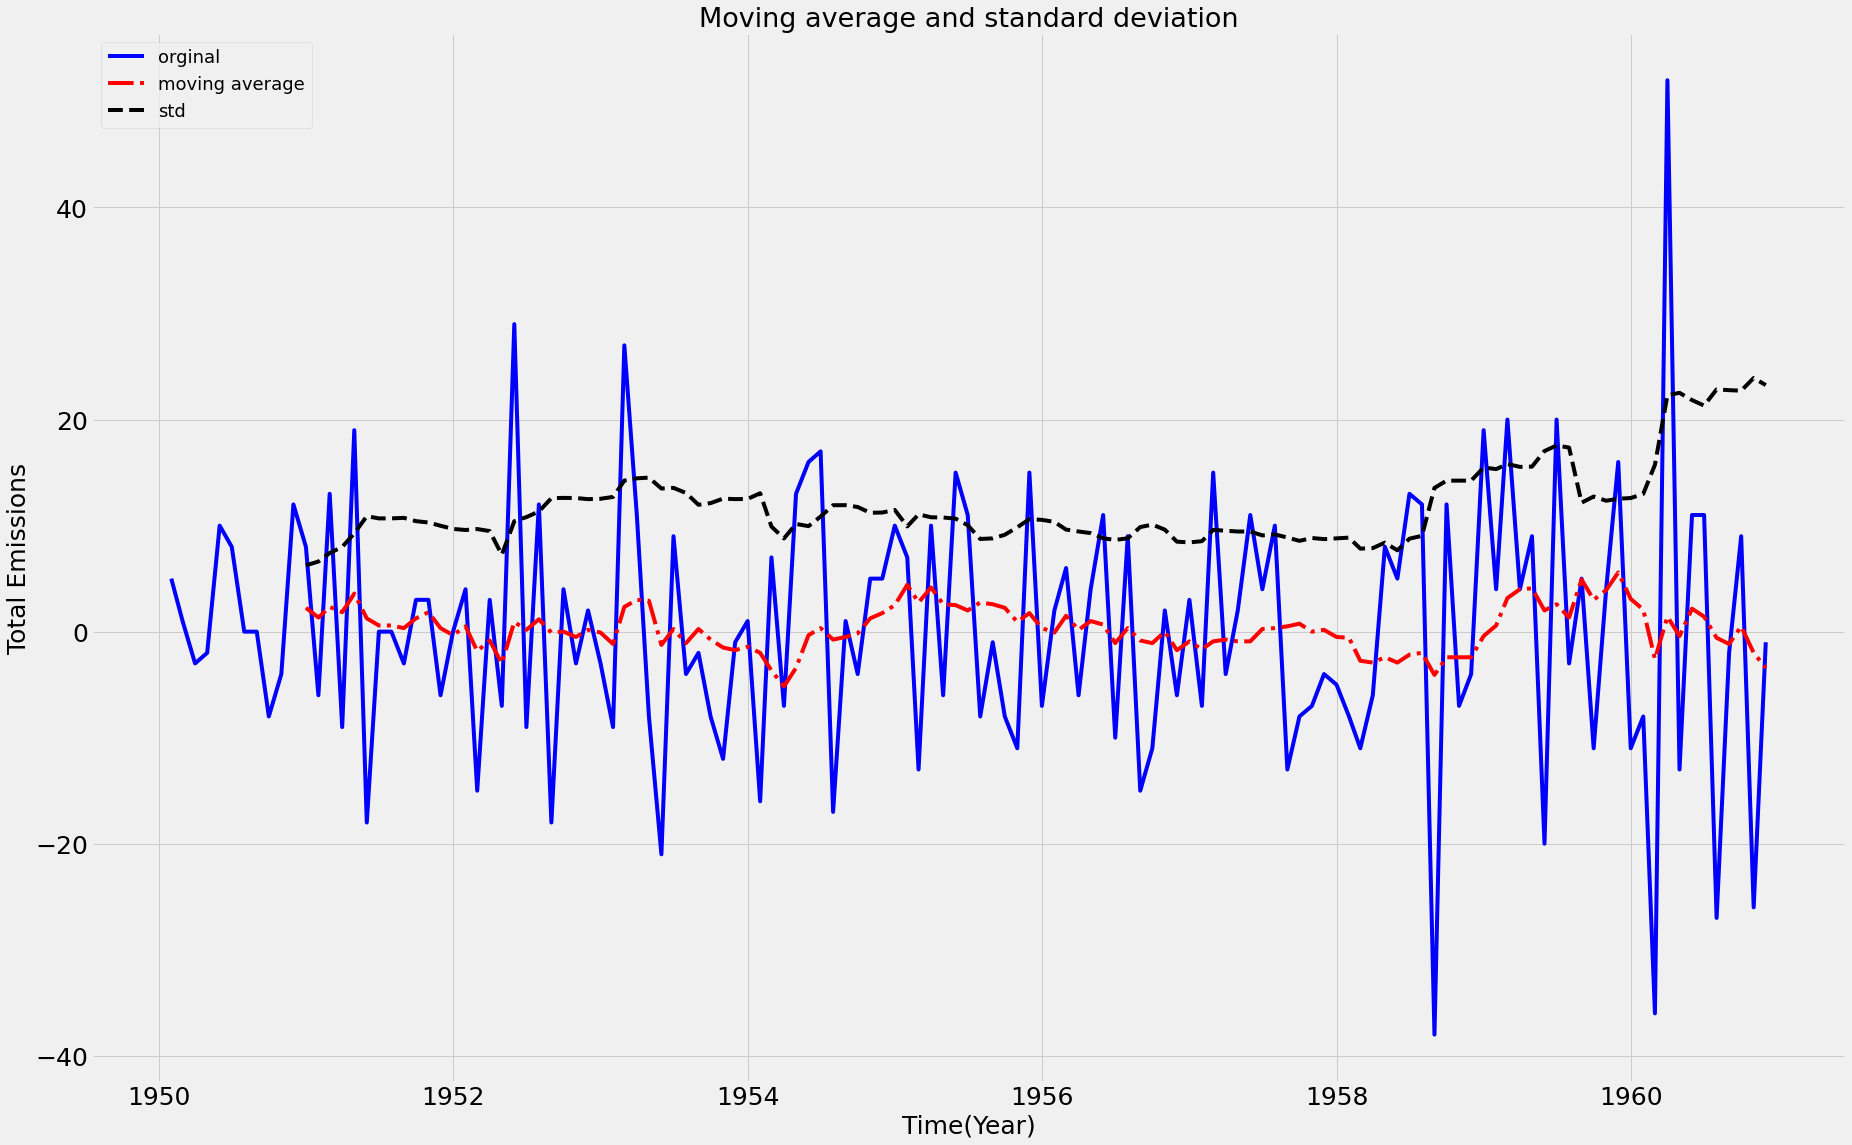

Test Statistic                  -1.559562e+01
p-value                          1.856512e-28
#Lags Used                       0.000000e+00
Number of Oberservations Used    1.300000e+02
Critical Value (1%)             -3.481682e+00
Critical Value (5%)             -2.884042e+00
Critical Value (10%)            -2.578770e+00
dtype: float64
Reject Null hypothesis, the time series is stable


In [11]:
ts_first_difference = ts - ts.shift(1)
ts_seasonal_first_difference = ts_first_difference - ts_first_difference.shift(12)
TestStationaryPlot(ts_seasonal_first_difference.dropna(inplace=False))
TestStationaryAdfuller(ts_seasonal_first_difference.dropna(inplace=False))

In [12]:
ts_seasonal_first_difference.dropna(inplace = True)
r,q,p = sm.tsa.acf(ts_seasonal_first_difference.values.squeeze(), qstat=True) 
data = np.c_[range(1,22), r[1:], q, p] 
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"]) 
print(table.set_index('lag'))

            AC          Q  Prob(>Q)
lag                                
1.0  -0.309815  12.864220  0.000335
2.0   0.095351  14.092191  0.000871
3.0  -0.096891  15.370038  0.001526
4.0  -0.098995  16.714492  0.002196
5.0   0.061001  17.229035  0.004085
6.0  -0.000288  17.229047  0.008477
7.0  -0.056108  17.671389  0.013544
8.0  -0.060966  18.197879  0.019791
9.0   0.175917  22.617432  0.007115
10.0 -0.140279  25.450926  0.004553
11.0  0.069735  26.156996  0.006150
12.0 -0.133673  28.773167  0.004257
13.0  0.087177  29.895308  0.004876
14.0  0.002494  29.896234  0.007887
15.0  0.065332  30.537324  0.010125
16.0 -0.109162  32.342697  0.009021
17.0 -0.000338  32.342714  0.013638
18.0  0.044028  32.641592  0.018436
19.0 -0.113945  34.661340  0.015337
20.0 -0.091271  35.968925  0.015511
21.0  0.041943  36.247565  0.020506


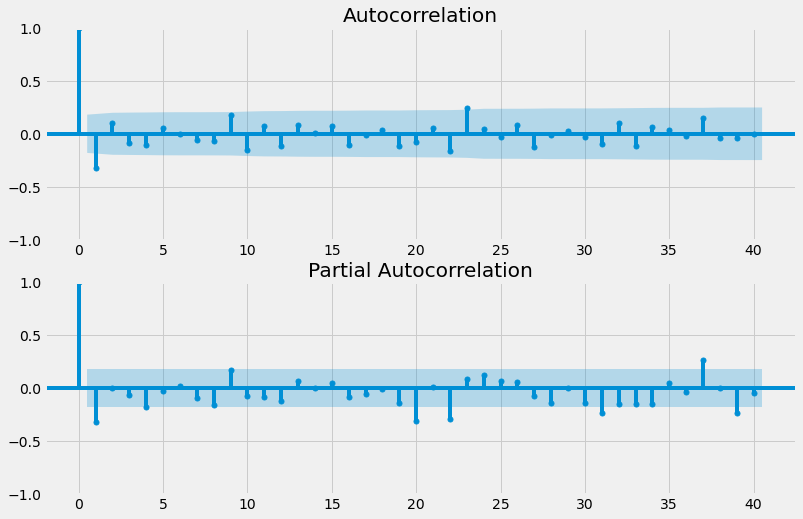

In [13]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_seasonal_first_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_seasonal_first_difference.iloc[13:], lags=40, ax=ax2)
plt.show()

In [14]:
p = d = q = range(0, 2) 
pdq = list(itertools.product(p, d, q)) 
pdq_x_PDQs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] 
a=[]
b=[]
c=[]
wf=pd.DataFrame()
for param in pdq:
    for seasonal_param in pdq_x_PDQs:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts,order=param,seasonal_order=seasonal_param,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, seasonal_param, results.aic))
            a.append(param)
            b.append(seasonal_param)
            c.append(results.aic)
        except:
            continue
wf['pdq']=a
wf['pdq_x_PDQs']=b
wf['aic']=c
print(wf[wf['aic']==wf['aic'].min()])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.09179D+00    |proj g|=  1.97105D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      2      1     0     0   1.696D-06   7.092D+00
  F =   7.0917810716762455     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:2044.4329486427587
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:1886.6012941219583
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.56433D+00    |proj g|=  2.59496D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      4      1     0     0   4.773D-06   4.562D+00
  F =   4.5622263644007655     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:1315.9211929474204
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  3.82631D+00    |proj g|=  2.06607D-02

At iterate   15    f=  3.82614D+00    |proj g|=  3.42154D-01

At iterate   20    f=  3.82382D+00    |proj g|=  6.87675D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     26      1     0     0   2.470D-04   3.824D+00
  F =   3.8238062650129603     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:1107.2562043237326
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.56812D+00    |proj g|=  1.00502D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     24      1     0     0   8.274D-07   3.568D+00
  F =   3.5681153356702118     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:1033.617216673021
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.84688D+00    |proj g|=  7.05433D-01

At iterate    5    f=  6.69222D+00    |proj g|=  7.18571D-02

At iterate   10 

 This problem is unconstrained.



At iterate   15    f=  6.07489D+00    |proj g|=  1.95272D-02

At iterate   20    f=  6.03622D+00    |proj g|=  1.81128D-01

At iterate   25    f=  5.53189D+00    |proj g|=  2.53804D-01

At iterate   30    f=  5.42406D+00    |proj g|=  3.09395D-02

At iterate   35    f=  5.42358D+00    |proj g|=  4.47260D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     35     56      1     0     0   4.473D-06   5.424D+00
  F =   5.4235820528890741     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:1567.9916312320534
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.83184D+00    |proj g|=  6.94733D-02

At iterate   10    f=  3.70296D+00    |proj g|=  2.89721D-02

At iterate   15    f=  3.70187D+00    |proj g|=  5.29181D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     18      1     0     0   5.292D-06   3.702D+00
  F =   3.7018690916820693     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:1072.138298404436
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:1071.0026810183701
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.17976D+00    |proj g|=  7.27127D-01

At iterate    5    f=  5.99755D+00    |proj g|=  2.94442D-03

At iterate   10    f=  5.97325D+00    |proj g|=  2.04492D-01

At iterate   15    f=  5.83062D+00    |proj g|=  1.26919D-01

At iterate   20    f=  4.65527D+00    |proj g|=  1.01733D+01

At iterate   25    f=  3.63335D+00    |proj g|=  2.77866D-01

At iterate   30    f=  3.61660D+00    |proj g|=  9.63627D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.39548D+00    |proj g|=  1.26013D-01

At iterate   20    f=  3.39352D+00    |proj g|=  1.79572D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     30      1     0     0   1.324D-04   3.394D+00
  F =   3.3935230826505314     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:985.334647803353
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.87158D+00    |proj g|=  4.06841D-04

           * * *


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.24236D+00    |proj g|=  1.20348D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5     10      1     0     0   1.203D-07   3.242D+00
  F =   3.2423594671460263     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC:937.7995265380556
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.56765D+00    |proj g|=  2.99222D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of f

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.24337D+00    |proj g|=  4.28483D-03

At iterate   10    f=  3.24282D+00    |proj g|=  6.72831D-02

At iterate   15    f=  3.24236D+00    |proj g|=  1.82956D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     20      1     0     0   4.250D-06   3.242D+00
  F =   3.2423556849494295     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(1, 1, 1, 12) - AIC:939.7984372654357
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.48207D+00    |proj g|=  8.47786D-03

At iterate    5    f=  3.48196D+00    |proj g|=  5.82784D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     11      1     0     0   2.635D-06   3.482D+00
  F =   3.4819163359023104     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 1, 0, 12) - AIC:1006.7919047398655
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0   

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     22      1     0     0   1.087D-05   3.501D+00
  F =   3.5007774416060209     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(1, 0, 0, 12) - AIC:1014.2239031825341
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03178D+00    |proj g|=  1.11110D-01

At iterate    5    f=  3.98298D+00    |proj g|=  5.78340D-02

At iterate   10    f=  3.73187D+00    |proj g|=  2.93888D+00

At iterate   15

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22549D+00    |proj g|=  2.34536D-02

At iterate    5    f=  3.22500D+00    |proj g|=  1.34089D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     11      1     0     0   1.026D-05   3.225D+00
  F =   3.2249914672740014     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(1, 1, 0, 12) - AIC:934.7975425749124
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28104D+00    |proj g|=  1.84778D-01

At iterate    5    f=  3.25884D+00    |proj g|=  3.58030D-03

At iterate   10    f=  3.25841D+00    |proj g|=  3.88793D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     18      1     0     0   2.478D-06   3.258D+00
  F =   3.2582829588656868     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(0, 1, 1, 12) - AIC:944.3854921533178
RUNNING THE L-BFG

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.09641D+00    |proj g|=  5.43300D-02

At iterate    5    f=  4.08266D+00    |proj g|=  1.33366D-01

At iterate   10    f=  4.05295D+00    |proj g|=  1.35858D-01

At iterate   15    f=  3.77303D+00    |proj g|=  9.81793D-01

At iterate   20    f=  3.48941D+00    |proj g|=  2.46864D-01

At iterate   25    f=  3.46885D+00    |proj g|=  8.13653D-03

At iterate   30    f=  3.46884D+00    |proj g|=  7.54246D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.26009D+00    |proj g|=  1.30313D-01

At iterate   20    f=  3.25619D+00    |proj g|=  9.07958D-03

At iterate   25    f=  3.25500D+00    |proj g|=  4.37788D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     30      1     0     0   8.693D-07   3.255D+00
  F =   3.2550003009953405     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(1, 1, 1, 12) - AIC:945.4400866866581
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  4.15454D+00    |proj g|=  3.47043D-01

At iterate   20    f=  4.11215D+00    |proj g|=  7.01792D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     31      1     0     0   3.129D-05   4.112D+00
  F =   4.1121352887567708     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(0, 0, 1, 12) - AIC:1192.29496316195
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.50099D+00    |proj g|=  9.01844D-03

At iterate    5  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.19947D+00    |proj g|=  2.25405D-02

At iterate   20    f=  3.19942D+00    |proj g|=  3.51550D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     24      1     0     0   3.515D-06   3.199D+00
  F =   3.1994200374625628     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(0, 1, 1, 12) - AIC:929.4329707892181
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.09075D+00    |proj g|=  1.76922D-01

At iterate    5 

 This problem is unconstrained.



At iterate    5    f=  4.00106D+00    |proj g|=  3.08324D-02

At iterate   10    f=  3.96239D+00    |proj g|=  1.32323D-01

At iterate   15    f=  3.48482D+00    |proj g|=  1.62011D+00

At iterate   20    f=  3.40995D+00    |proj g|=  2.05793D-01

At iterate   25    f=  3.40078D+00    |proj g|=  1.12911D-01

At iterate   30    f=  3.39993D+00    |proj g|=  9.60676D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   35    f=  3.39992D+00    |proj g|=  2.30392D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     86      2     0     0   2.304D-05   3.400D+00
  F =   3.3999183113536926     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 0, 1, 12) - AIC:989.1764736698635
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.53452D+00    |proj g|=  6.39587D-01

At iterate    5    f=  3.22261D+00    |proj g|=  8.92765D-02

At iterate   10 

 This problem is unconstrained.



At iterate    5    f=  3.21862D+00    |proj g|=  1.22467D-02

At iterate   10    f=  3.21743D+00    |proj g|=  3.03053D-02

At iterate   15    f=  3.21676D+00    |proj g|=  1.64663D-02

At iterate   20    f=  3.21504D+00    |proj g|=  1.28350D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     28      1     0     0   1.877D-05   3.215D+00
  F =   3.2149836321389396     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 1, 1, 12) - AIC:935.9152860560146
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0  

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.20574D+00    |proj g|=  8.39406D-02

At iterate    5    f=  3.20223D+00    |proj g|=  6.98478D-03

At iterate   10    f=  3.20184D+00    |proj g|=  3.98828D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   3.378D-06   3.202D+00
  F =   3.2018447351755253     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(0, 1, 1, 12) - AIC:928.1312837305513
RUNNING THE L-BFG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.19494D+00    |proj g|=  5.16971D-04

At iterate   15    f=  3.19494D+00    |proj g|=  1.70109D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     19      1     0     0   5.288D-07   3.195D+00
  F =   3.1949370208977150     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(1, 1, 1, 12) - AIC:928.1418620185419
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.78049D+00    |proj g|=  4.87980D-02

At iterate    5 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   10    f=  4.10102D+00    |proj g|=  2.07613D-01

At iterate   15    f=  4.08799D+00    |proj g|=  1.52479D-03

At iterate   20    f=  4.08797D+00    |proj g|=  2.00699D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     30      1     0     0   5.695D-06   4.088D+00
  F =   4.0879654026712764     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 0, 1, 12) - AIC:1185.3340359693275
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.67274D+00    |proj g|=  2.87783D-01

At iterate   15    f=  3.42073D+00    |proj g|=  4.95998D-02

At iterate   20    f=  3.39841D+00    |proj g|=  3.86011D-02

At iterate   25    f=  3.39333D+00    |proj g|=  9.28359D-03

At iterate   30    f=  3.39283D+00    |proj g|=  1.80938D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     46      1     0     0   1.053D-05   3.393D+00
  F =   3.3928261335663206     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 0, 1, 12) - AIC:987.1339264671003
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  3.19993D+00    |proj g|=  1.83616D-03

At iterate   10    f=  3.19992D+00    |proj g|=  5.57963D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     15      1     0     0   3.909D-06   3.200D+00
  F =   3.1999153501148272     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(1, 1, 0, 12) - AIC:929.5756208330703
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.17887D+00    |proj g|=  8.27757D-02

At iterate    5  

In [15]:
print(wf[wf['aic']==wf['aic'].min()])

          pdq     pdq_x_PDQs         aic
31  (0, 1, 1)  (1, 1, 1, 12)  920.319297


In [16]:
mod = sm.tsa.statespace.SARIMAX(ts, 
                                order=(0,1,1), 
                                seasonal_order=(1,1,1,12),   
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.17905D+00    |proj g|=  7.64607D-02

At iterate    5    f=  3.16815D+00    |proj g|=  1.48548D-02

At iterate   10    f=  3.16779D+00    |proj g|=  1.57725D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     17      1     0     0   9.418D-06   3.168D+00
  F =   3.1677753385378296     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                  

 This problem is unconstrained.


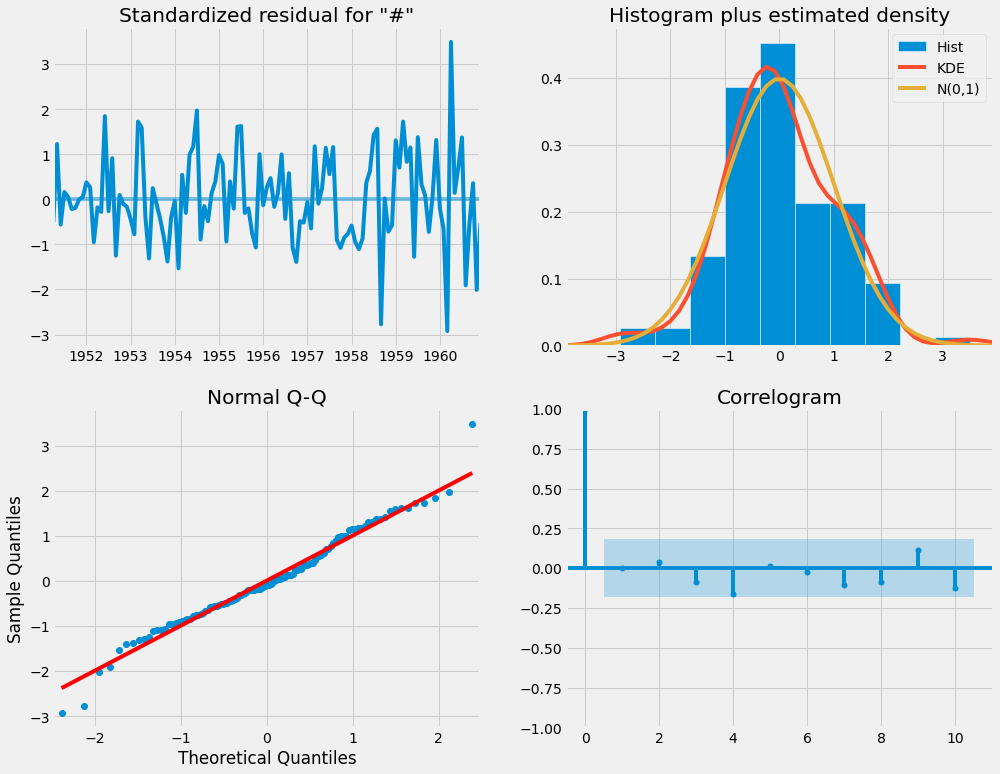

            AC          Q  Prob(>Q)
lag                                
1.0  -0.011218   0.018502  0.891802
2.0   0.060367   0.558044  0.756523
3.0  -0.019945   0.617356  0.892448
4.0  -0.097853   2.055275  0.725593
5.0   0.046487   2.382135  0.794132
6.0  -0.005224   2.386293  0.880970
7.0  -0.094454   3.755406  0.807479
8.0  -0.072159   4.560328  0.803368
9.0   0.023967   4.649784  0.863707
10.0 -0.122705   7.012066  0.724305
11.0  0.048844   7.389198  0.766747
12.0 -0.093226   8.773450  0.722149
13.0  0.057935   9.312128  0.748983
14.0  0.034872   9.508796  0.797143
15.0  0.013867   9.540134  0.847627
16.0 -0.097660  11.106654  0.802855
17.0  0.023361  11.196999  0.846142
18.0  0.013501  11.227412  0.884458
19.0 -0.117521  13.550344  0.809245
20.0 -0.057139  14.103907  0.825189
21.0 -0.037600  14.345560  0.854303


In [17]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

r,q,p = sm.tsa.acf(results.resid.values.squeeze(), qstat=True) 
data = np.c_[range(1,22), r[1:], q, p] 
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"]) 
print(table.set_index('lag'))

In [22]:
pred = results.get_prediction(start = pd.to_datetime('1959-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ts_forecast = pred.predicted_mean
ts_truth = ts['1959-01-01':]
ts_pred_concat = pd.concat([ts_truth, ts_forecast,pred_ci],axis=1)
ts_pred_concat.columns = ['Original Value','Predicted Value','Lower Bound','Upper Bound']
ts_pred_concat.head(15)

,Original Value,Predicted Value,Lower Bound,Upper Bound
1959-01-01,360,344.492063,321.277701,367.706425
1959-02-01,342,333.651734,310.437375,356.866092
1959-03-01,406,385.551017,362.336660,408.765375
1959-04-01,396,386.110081,362.895723,409.324439
1959-05-01,420,406.375892,383.161534,429.590250
1959-06-01,472,487.097560,463.883202,510.311918
1959-07-01,548,531.645078,508.430720,554.859435
1959-08-01,559,555.061447,531.847089,578.275805
1959-09-01,463,462.022752,438.808394,485.237110
1959-10-01,407,415.552712,392.338355,438.767070


In [23]:
ts_forecast

1959-01-01    344.492063
1959-02-01    333.651734
1959-03-01    385.551017
1959-04-01    386.110081
1959-05-01    406.375892
1959-06-01    487.097560
1959-07-01    531.645078
1959-08-01    555.061447
1959-09-01    462.022752
1959-10-01    415.552712
1959-11-01    361.295260
1959-12-01    389.399182
1960-01-01    419.385964
1960-02-01    398.845773
1960-03-01    453.632204
1960-04-01    419.604806
1960-05-01    470.295052
1960-06-01    526.605528
1960-07-01    605.724120
1960-08-01    628.596411
1960-09-01    514.633982
1960-10-01    456.758920
1960-11-01    413.795935
1960-12-01    438.283327
Freq: MS, Name: predicted_mean, dtype: float64

In [28]:
ts_forecast1 = pd.DataFrame(ts_forecast)
ts_forecast1['predicted_mean'] = ts_forecast1['predicted_mean'].astype(int)
ts_forecast1

,predicted_mean
1959-01-01,344
1959-02-01,333
1959-03-01,385
1959-04-01,386
1959-05-01,406
1959-06-01,487
1959-07-01,531
1959-08-01,555
1959-09-01,462
1959-10-01,415


In [30]:
ts_forecast1['predicted_mean']

1959-01-01    344
1959-02-01    333
1959-03-01    385
1959-04-01    386
1959-05-01    406
1959-06-01    487
1959-07-01    531
1959-08-01    555
1959-09-01    462
1959-10-01    415
1959-11-01    361
1959-12-01    389
1960-01-01    419
1960-02-01    398
1960-03-01    453
1960-04-01    419
1960-05-01    470
1960-06-01    526
1960-07-01    605
1960-08-01    628
1960-09-01    514
1960-10-01    456
1960-11-01    413
1960-12-01    438
Freq: MS, Name: predicted_mean, dtype: int64

In [25]:
ts_truth

,#Passengers
Month,
1959-01-01,360
1959-02-01,342
1959-03-01,406
1959-04-01,396
1959-05-01,420
1959-06-01,472
1959-07-01,548
1959-08-01,559
1959-09-01,463


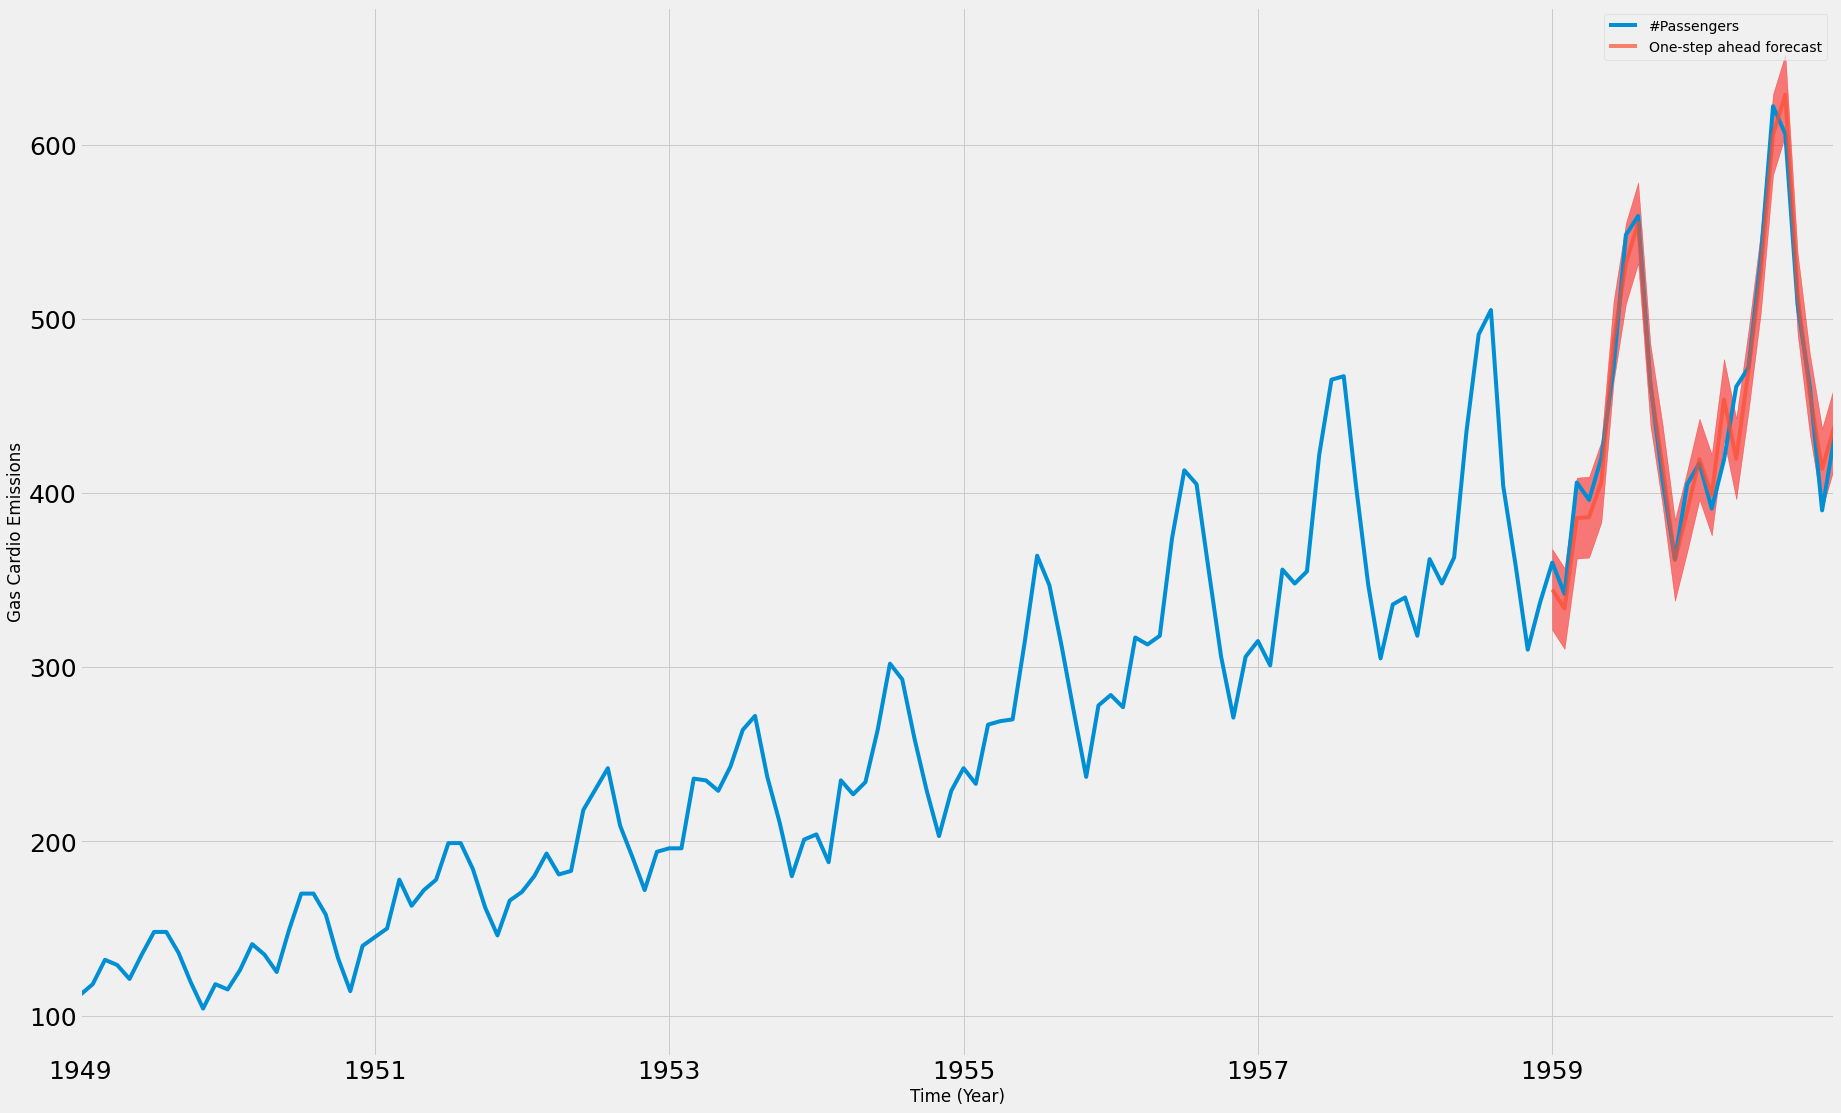

In [24]:
ax = ts['1949':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast', alpha=.7)
ax.fill_between(pred_ci.index,pred_ci.iloc[:,0],pred_ci.iloc[:,1], color='r', alpha=.5)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
ax.set_xlabel('Time (Year)')
ax.set_ylabel('Gas Cardio Emissions')
plt.legend()
plt.show()

In [34]:
ape = np.abs((ts_truth['#Passengers'] - ts_forecast1['predicted_mean']) / ts_truth['#Passengers']).sum()

In [40]:
mape = ape / len(ts_truth['#Passengers']) * 100
mape

2.8761563471918143

In [41]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1959-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()
ts_forecast = pred_dynamic.predicted_mean
ts_orginal = ts['1959-01-01':]
ts_pred_concat = pd.concat([ts_orginal, ts_forecast,pred_ci],axis=1)
ts_pred_concat.columns = ['Original Value','Predicted Value','Lower Bound','Upper Bound']
ts_pred_concat.head(15)

,Original Value,Predicted Value,Lower Bound,Upper Bound
1959-01-01,360,344.492063,321.277701,367.706425
1959-02-01,342,323.340419,310.437375,356.866092
1959-03-01,406,369.688894,362.336660,408.765375
1959-04-01,396,356.651316,362.895723,409.324439
1959-05-01,420,370.341265,383.161534,429.590250
1959-06-01,472,442.004188,463.883202,510.311918
1959-07-01,548,496.590157,508.430720,554.859435
1959-08-01,559,509.132048,531.847089,578.275805
1959-09-01,463,413.474588,438.808394,485.237110
1959-10-01,407,366.354770,392.338355,438.767070


In [44]:
ts_forecast2 = pd.DataFrame(ts_forecast)
ts_forecast2['predicted_mean'] = ts_forecast2['predicted_mean'].astype(int)
ts_forecast2

,predicted_mean
1959-01-01,344
1959-02-01,323
1959-03-01,369
1959-04-01,356
1959-05-01,370
1959-06-01,442
1959-07-01,496
1959-08-01,509
1959-09-01,413
1959-10-01,366


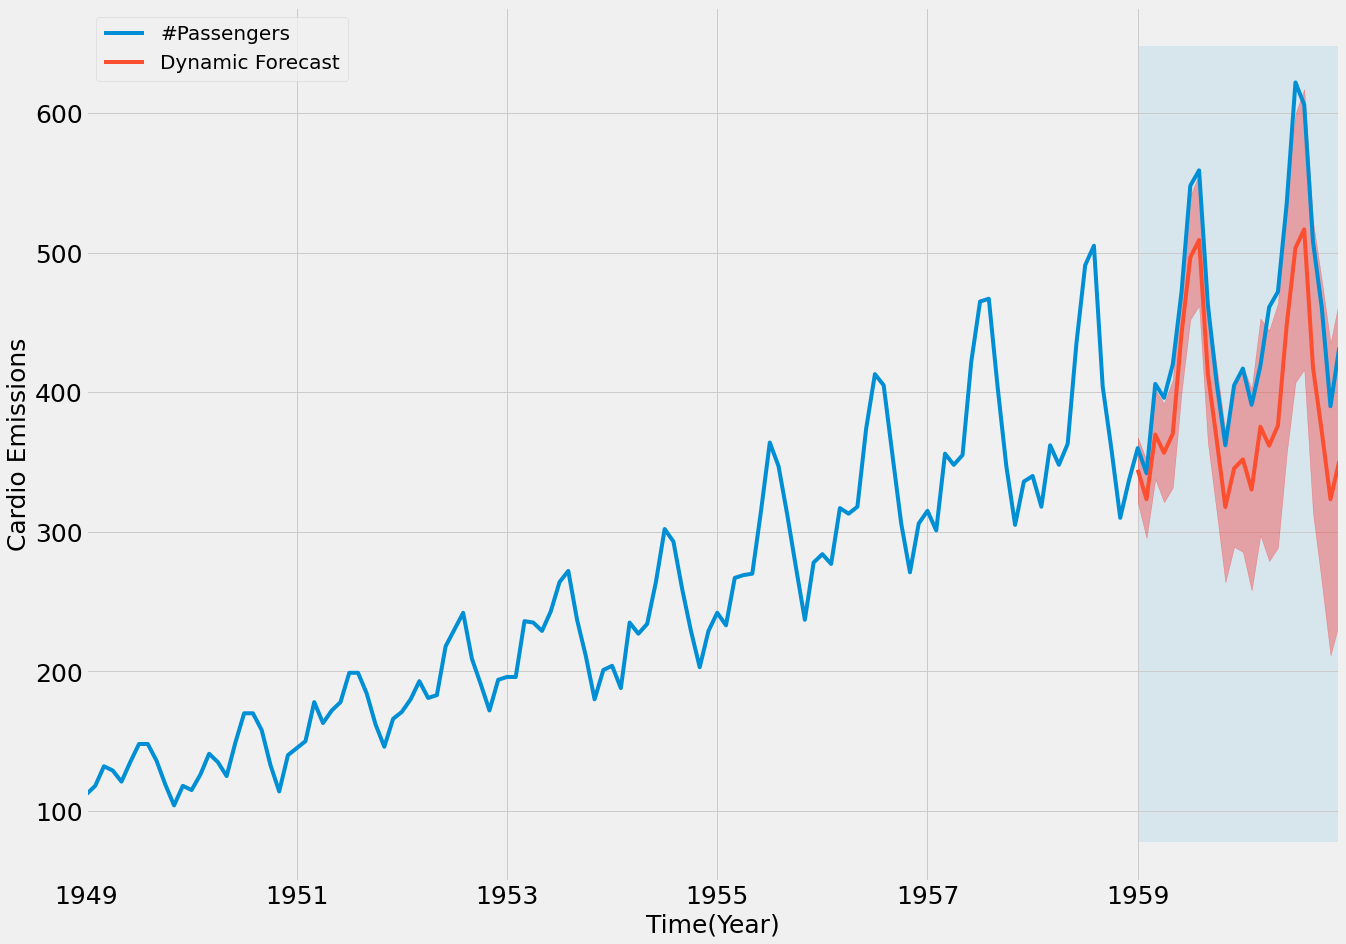

In [45]:
ax = ts['1949':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)
ax.fill_between(pred_dynamic_ci.index,pred_dynamic_ci.iloc[:, 0],pred_dynamic_ci.iloc[:, 1],color='r',alpha=.3)
ax.fill_betweenx(ax.get_ylim(),pd.to_datetime('1959-01-31'),ts.index[-1],alpha=.1, zorder=-1)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
ax.set_xlabel('Time(Year)',fontsize=25)
ax.set_ylabel('Cardio Emissions',fontsize=25)
plt.legend(loc = 'upper left',fontsize=20)
plt.show()

In [46]:
ape1 = np.abs((ts_truth['#Passengers'] - ts_forecast2['predicted_mean']) / ts_truth['#Passengers']).sum()

In [47]:
mape1 = ape1 / len(ts_truth['#Passengers']) * 100

In [48]:
mape1

13.400124512424247

In [50]:
ts_forecast1

,predicted_mean
1959-01-01,344
1959-02-01,333
1959-03-01,385
1959-04-01,386
1959-05-01,406
1959-06-01,487
1959-07-01,531
1959-08-01,555
1959-09-01,462
1959-10-01,415


In [51]:
ts_forecast1.to_csv('submission.csv')

In [ ]:
ts_forecast1 = ts_forecast1(columns)

In [54]:
submission = pd.DataFrame({ 'Date': ts_forecast1.index, 'Passengers': ts_forecast1.predicted_mean.values })
submission.to_csv("my_submission.csv", index=False)

In [53]:
ts_forecast1.index.values

array(['1959-01-01T00:00:00.000000000', '1959-02-01T00:00:00.000000000',
       '1959-03-01T00:00:00.000000000', '1959-04-01T00:00:00.000000000',
       '1959-05-01T00:00:00.000000000', '1959-06-01T00:00:00.000000000',
       '1959-07-01T00:00:00.000000000', '1959-08-01T00:00:00.000000000',
       '1959-09-01T00:00:00.000000000', '1959-10-01T00:00:00.000000000',
       '1959-11-01T00:00:00.000000000', '1959-12-01T00:00:00.000000000',
       '1960-01-01T00:00:00.000000000', '1960-02-01T00:00:00.000000000',
       '1960-03-01T00:00:00.000000000', '1960-04-01T00:00:00.000000000',
       '1960-05-01T00:00:00.000000000', '1960-06-01T00:00:00.000000000',
       '1960-07-01T00:00:00.000000000', '1960-08-01T00:00:00.000000000',
       '1960-09-01T00:00:00.000000000', '1960-10-01T00:00:00.000000000',
       '1960-11-01T00:00:00.000000000', '1960-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')